# Learn to Score a Tic-Tac-Toe Board by Example

## Introduction 

We want to use machine learning (ML) to support intelligent agents playing Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). 
Games are sequential decision making problems that can be solved using heuristic tree search. 
Here we try to learn an evaluation function `eval()` that predicts the utility of a non-terminal board.
The idea is to use supervised learning to train a regression model on training data created using simulation.

### The Data Generating Function $f(\cdot)$
To apply supervised learning we assume that 
there exists a function $$y = f(x),$$
with $y \in [-1,1]$ that maps a board (state $s$) represented by the feature 
vector $x$ to the true utility of the state $U(s)$ given the playout policies that both players are using. 
For terminal states, we can observe a value for this function. But for non-terminal state, we need to learn an approximation.

The actual game outcomes in data that we observe depends not just on the current board but also on both 
   players' playout policies. 
   We call the two playout policies $\pi_x$ and $\pi_o$. 
   If the policies are stochastic, then the function $f(\cdot)$ will also be stochastic. This means the same board can lead to a win (+1), a loss (-1) or a draw (0),
   depending on what moves are chosen by the players.
   One way to interpret this is to say that our observations have a random error or are noisy which is fine for ML. 
   For stochastic functions, we need to work with expectations. We model $$\mathbb{E}_{\pi_x,\pi_o}[U(s)] = y = f(x_s),$$ 
   with the
   expectation taken over the two players' playout policies $\pi_x$ and $\pi_o$. For simple two-player, zero-sum games 
   it has been shown 
   that the expected state utility of random play is proportional to the expected utility under the optimal policies, so we can
   use random playout policies. Essentially, better boards are more likely to lead to a win no matter the policy. 


### The ML Model

The expected utility is a continuous variable so we use regression.
We want to learn a function to predict the expected utility: $$h(x_s) = \hat{y} \approx \mathbb{E}_{\pi_x,\pi_o}[U(s)].$$

We do not expect a linear relationship, so linear regression will not work.
For regression, we typically minimize the 
$L_2(\hat{y}, y)$ loss. 

### Training Data
We can create training data by observing (or simulating) games and recording all board positions as the 
   feature matrix $X$ and the information if they lead to a win, 
   loss or draw as the vector $y$. 

The training data is typically generated using simulation which also uses a playout strategy. We will use a 
simple random policy. 

An even better approach would be to use "self-play." Here the current ML model is used as the playout policy for two copies of the agent playing each other (it is called self-play because the agent basically plays itself). We update the models after each new game finishes and keep on playing. The idea is that the agent will generate better and better data to improve the model. Considerations for self-play including temporal credit assignment and the need to introduce variability into the process can be found in [Tesauro (1995)](https://dl.acm.org/doi/10.1145/203330.203343).

### Using the ML Model in the Agent 
The ML model can be used in intelligent agents in several ways:  
   - We can choose an action in state $s$ by maximizing the predicted expected utility of the state after the action: $$a^* = \mathrm{argmax}_{a \in \mathrm{available\_actions}(s)}\ h(\mathrm{result}(s, a)).$$
   
   This is a direct application of the maximum 
   expected utility principle. 
   
   - We can use $$\mathrm{eval(s)} = h(s)$$ as the heuristic evaluation function for heuristic minimax cutoff search.

Note that the first option is actually a special case of the second where the cutoff is 1.

## Implementation

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py). 

In [25]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

In [26]:
%precision 3
%pip install -q numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import math

Note: you may need to restart the kernel to use updated packages.


### Create Training Data using Playouts

We need to create board as the matrix $X$ and the game results as vector $y$. Note that each player sees different 
boards and we need to train a model for a specific player. Here we create data to train a model for player x
by only using the boards resulting from a move of that player.  

ML algorithms need numeric inputs.
To describe $x$ for the learning algorithm, I translate empty cells to 0, `x` to 1 and `o` to -1.

In [27]:
tr = {' ': 0, 'x': 1, 'o': -1} # I translate the board into numbers

def encode_state(state):
    """Represent the board as a vector of numbers."""
    return [tr[s] for s in state]

#### Playouts

We will simulate the training data with a **randomized playout policy.**

In [28]:
def playout_policy_random(state, player = 'x'):
    return np.random.choice(actions(state))
    
playout_policy = playout_policy_random
playout_policy(empty_board())

np.int64(1)

#### Credit Assignment

We need to assign utility to all boards in the game. This is called in AI **credit assignment problem** which assigns credit to
intermediate states which lead to a final state that has a utility defined.
I implement here a very simple credit assignment strategy that attribute 100% of the utility to the terminal board and then reduce the assigned utility using a decay factor. 
The example is for the boards in a game with 3 moves by x that leads to a loss.

In [29]:
def credit_assignment(u, len, decay = .8):
    return [u * decay ** (x-1) for x in range(len, 0, -1)] 

credit_assignment(-1, 3)

[-0.640, -0.800, -1.000]

Record a single game for player x.

In [30]:
def playout_record(player = 'x'):
    """Run a playout and record the boards after the player's move."""
    state = empty_board()
    current_player = 'x'
    
    boards = []
    
    while(True):
        # reached terminal state? Perform credit assignment
        u = utility(state, player)
        if u is not None: return(boards, credit_assignment(u, len(boards)))
  
        # next action
        a = playout_policy(state, current_player)
        state = result(state, current_player, a)   
  
        # only store boards for the player
        if current_player == player:
            boards.append(encode_state(state))

        # switch between players
        current_player = other(current_player)

playout_record()

([[0, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, -1, 0, 0, 1, 0, 1, 0],
  [0, -1, -1, 0, 1, 1, 0, 1, 0],
  [0, -1, -1, -1, 1, 1, 1, 1, 0],
  [1, -1, -1, -1, 1, 1, 1, 1, -1]],
 [0.000, 0.000, 0.000, 0.000, 0.000])

Run `N` playouts and create a pandas dataframe for `X` and a numpy array for `y`. These data structures work for `sklearn`. 

In [31]:
def create_data(N, record = 'x'):
    board = []
    utility = []
    
    for i in range(N):
        b, u = playout_record(record)
        board.extend(b)
        utility.extend(u)
        
    return [pd.DataFrame(board), np.array(utility)]


np.random.seed(1234)

X, y = create_data(5000)

print("X:")
display(X)

print("y:")
display(y)

X:


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,-1,0
2,0,0,0,1,0,-1,1,-1,1
3,-1,0,1,1,0,-1,1,-1,1
4,-1,1,1,1,-1,-1,1,-1,1
...,...,...,...,...,...,...,...,...,...
20838,0,0,0,0,0,0,1,0,0
20839,0,0,0,-1,0,0,1,0,1
20840,0,1,0,-1,-1,0,1,0,1
20841,-1,1,1,-1,-1,0,1,0,1


y:


array([0.  , 0.  , 0.  , ..., 0.64, 0.8 , 1.  ], shape=(20843,))

Each row in `X` is a board and the values in `y` are the corresponding outcome in the simulated game.

### Fit a Regression Model

Since we want to learn to predict a number (the utility), we have a regression problem.
We learn an artificial neural network called a Multi-layer Perceptron **Regressor** in scikit-learn.

See
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

ANNs are popular for this kind of task but other regression models can also be used.

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, explained_variance_score

Split the data in training and testing data so we can evaluate generalization performance.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Fit the model.

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(loss='squared_error',
                   hidden_layer_sizes = (200), 
                   early_stopping= True, 
                   alpha = 0.001,
                   max_iter = 1000
                   ) 
                    
%time mlp.fit(X_train, y_train)


CPU times: user 43.2 s, sys: 57.7 ms, total: 43.3 s
Wall time: 3.62 s


,loss,'squared_error'
,hidden_layer_sizes,200
,activation,'relu'
,solver,'adam'
,alpha,0.001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True


The model has 9 inputs, 200 hidden neurons and a single output neuron.
Model size as number of neurons per layer and total number of weights.

In [35]:
mlp.intercepts_[0].size

200

In [36]:
print("Layer 1:", np.shape(mlp.coefs_[0]))
print("Layer 2:", np.shape(mlp.coefs_[1]))

print("Total number of weights:", mlp.coefs_[0].size + mlp.intercepts_[0].size + 
      mlp.coefs_[1].size + mlp.intercepts_[1].size)

Layer 1: (9, 200)
Layer 2: (200, 1)
Total number of weights: 2201


### Test Model Performance

Test the model against the test data.

In [37]:
pred = mlp.predict(X_test)


#print("y_test:\t", list(y_test)[0:10])
#print("pred:\t",   pred[0:10])

print(pd.DataFrame({'y_test': list(y_test)[0:10], 'y_pred': pred[0:10]}))

print("RMSE:", root_mean_squared_error(y_test, pred))
print("MAE:", mean_absolute_error(y_test, pred))
print("Explained variance:", explained_variance_score(y_test, pred))

   y_test    y_pred
0 -0.6400  0.433643
1  0.4096  0.032689
2  0.0000  0.118943
3 -0.5120  0.141967
4 -1.0000 -1.124528
5  0.5120  0.141967
6  0.0000 -0.051354
7 -0.5120  0.028323
8  0.4096  0.131953
9  1.0000  0.759072
RMSE: 0.54097729505961
MAE: 0.44362805917149445
Explained variance: 0.3316726523960307


__Note:__ The error of the model is not great but remember, that we have a stochastic problem. We have two random players, so  the same board may lead to a win one time and to a loss the another time.

__More Notes:__ 

* The board is symmetric. You could use deep learning with convolution layers to create better models.
* The tic-tac-toe board is small and we used 5000 playouts. This covers a large space of the search space. If you have a more complicated game, 
    then you would need to do self-play to learn better and better playout policies.

## Tests On Boards

We evaluate some boards where `x` just made a move. The classifier tries to predict the most likely outcome
of the game as -1 = `o` wins, 0 = draw, and 1 = `x` wins. The classifier can also predict the probability of the three possible outcomes. We can use these probabilities as weights to calculate the expected utility in the range $[-1,1]$.

In [38]:
def print_eval_board(board):
    print("Board:")
    show_board(board)

    pred = mlp.predict(pd.DataFrame([encode_state(board)]))[0]
    print("\nPredicted expected utility:", pred)

### x will win

Board:


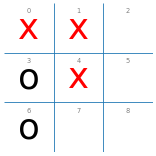


Predicted expected utility: 0.6555595759845032


In [39]:
board = ['x', 'x', ' ',
         'o', 'x', ' ',
         'o', ' ', ' ']

print_eval_board(board)

### x made a mistake and will lose

Board:


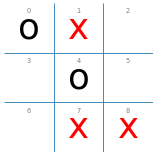


Predicted expected utility: -0.03355788338428427


In [40]:
board = ['o', 'x', ' ',
         ' ', 'o', ' ',
         ' ', 'x', 'x']
    
print_eval_board(board)

### This is going to be a draw

Board:


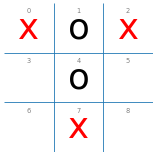


Predicted expected utility: -0.011323930429159135


In [41]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', 'x', ' ']

print_eval_board(board)

## Using the Predictions to find the Best Move

The predict function can be used for
   - the heuristic evaluation function for Heuristic Minimax Search.
   - a better playout policy for simulated games used in Pure Monte Carlo Search/Monte Carlo Tree Search. If we use it as a playout strategy to create more data for learning better ML models, then this is called _self-play_. 

I show here how to use the model as a heuristic evaluation function for all boards that the player `x` can get to with its next move. The player then chooses the move with the highest heuristic value (printed as "best action"). This is equivalent to heuristic minimax search with a cutoff at depth 1. 

In [42]:
def eval_fun_ML(state, player = 'x'):
    return mlp.predict(pd.DataFrame([encode_state(state)]))[0]
    

def ML_agent_function(state, player = 'x', verbose = False):  
    if (player != 'x'):
        raise Exception("I was only trained to play x!")
    action = None
    value = -math.inf

    for a in actions(state) : 
        b = result(state, player, a)
        val = eval_fun_ML(b, player)
        if (verbose):
            print("if %s chooses %d: predicted utility = %+1.2f" % (player, a, val))

        if val > value:
            value = val
            action = a
        
    return action

### Empty board: Place in the center (or at least a corner)

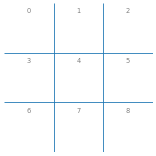

if x chooses 0: predicted utility = +0.16
if x chooses 1: predicted utility = +0.10
if x chooses 2: predicted utility = +0.12
if x chooses 3: predicted utility = +0.03
if x chooses 4: predicted utility = +0.22
if x chooses 5: predicted utility = +0.03
if x chooses 6: predicted utility = +0.14
if x chooses 7: predicted utility = +0.03
if x chooses 8: predicted utility = +0.13
Best action: 4
CPU times: user 7.1 ms, sys: 22 μs, total: 7.12 ms
Wall time: 6.35 ms


In [43]:
board = empty_board()
show_board(board)
%time print("Best action:", ML_agent_function(board, verbose = True))

### Play 7 to avoid a loss

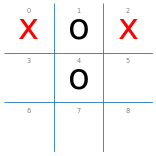

if x chooses 3: predicted utility = -0.28
if x chooses 5: predicted utility = -0.29
if x chooses 6: predicted utility = -0.34
if x chooses 7: predicted utility = -0.01
if x chooses 8: predicted utility = -0.26
Best action: 7
CPU times: user 0 ns, sys: 4.28 ms, total: 4.28 ms
Wall time: 3.84 ms


In [44]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', ' ', ' ']
show_board(board)
%time  print("Best action:", ML_agent_function(board, verbose = True))

### Play 4 to win

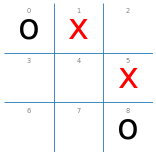

if x chooses 2: predicted utility = -0.78
if x chooses 3: predicted utility = -0.30
if x chooses 4: predicted utility = +0.38
if x chooses 6: predicted utility = -0.07
if x chooses 7: predicted utility = -0.35
Best action: 4
CPU times: user 3.88 ms, sys: 0 ns, total: 3.88 ms
Wall time: 3.46 ms


In [45]:
board = ['o', 'x', ' ',
         ' ', ' ', 'x',
         ' ', ' ', 'o']
show_board(board)
%time  print("Best action:", ML_agent_function(board, verbose = True))

## Play time

The evaluation function was only trained for player x so we cannot have it play for o.

In [46]:
print("ML vs. random:")
%time display(play(ML_agent_function, random_player))

ML vs. random:


{'x': 100, 'o': 0, 'd': 0}

CPU times: user 961 ms, sys: 25.7 ms, total: 987 ms
Wall time: 888 ms


## Some Concluding Notes 

* The learned evaluation function is not perfect.
* Tic-tac-toe is easy and learning an evaluation function for more complex games can be a lot harder. It may require deep learning with convolution or constructing an embedding for the board.
* We could create a stronger player by using the ML evaluation function in a **heuristic alpha-beta search.** 
* We could generate more (better) training data from observing the trained agent play and update the model. This is called approach is **self-play.**
* The approach is very similar to the reinforcement learning (RL) method called **neural fitted Q-learning (NFQ)**. In RL, the utility for taking an action in a state is called a Q-value $Q(s,a) = \mathbb{E}_{\pi_x,\pi_o}[U(result(s,a))]$ and the training set is called a replay memory.  